# ATP Maintenance Investigation

By Garrett Roell and Christina Schenk

Tested on biodesign_3.7 kernel on jprime

This notebook determines ATP maintenance flux in two ways. First, it plots the curve of the max growth rate vs. ATP flux, and determines where that line intersects the growth rate. Then it calculates the intersection point using flux variability analysis (FVA).

### Method: 
<ol>
<li>Setup imports</li>
<li>Load model and relevant data</li>
<li>Isolate wildtype phenol and glucose parameters</li>
    
<li>Run phenol FBA with many levels of ATP maintenance flux</li>
<li>Plot phenol growth rate vs. ATP maintenance flux</li>
<li>Run FVA to calculate phenol ATP maintenance flux value</li>
    
<li>Run glucose FBA with many levels of ATP maintenance flux</li>
<li>Plot glucose growth rate vs. ATP maintenance flux</li>
<li>Run FVA to calculate glucose ATP maintenance flux value</li>
</ol>

### 1. Setup imports

In [1]:
import pandas as pd
import sys
import matplotlib
from matplotlib import pyplot as plt
import cobra

SourceDir = '../src'
sys.path.append(SourceDir)
from cobra_functions import get_FBA_solution

### 2. Load model and relevant data

In [2]:
# load model
model = cobra.io.read_sbml_model('../models/r_opacus_annotated_curated.xml')

# load growth parameters
growth_parameters = pd.read_csv('../data/growth_rates/spot_growth_rates.csv', index_col=0)

growth_parameters

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,SPOT growth rate,SPOT growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,0.0,0.0
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,0.0,0.0
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.0,0.0


### 3. Isolate wildtype phenol and glucose parameters

In [3]:
phenol_uptake_rate = growth_parameters.loc['WT-P', 'substrate consumption rate']
phenol_growth_rate = growth_parameters.loc['WT-P', 'growth rate']

glucose_uptake_rate = growth_parameters.loc['WT-G', 'substrate consumption rate']
glucose_growth_rate = growth_parameters.loc['WT-P', 'growth rate']

### 4. Run phenol FBA with many levels of ATP maintenance flux

In [4]:
atp_growth_data = {}

# try every flux from 0 to 100 with a step of 10
for atp_maintenance_flux in range(0, 45, 5):
    # fix atp maintenance flux
    model.reactions.get_by_id('ATPM').lower_bound = atp_maintenance_flux
    model.reactions.get_by_id('ATPM').upper_bound = atp_maintenance_flux
    
    # run FBA
    phenol_fba_solution = get_FBA_solution(model, 'phenol', substrate_uptake_rate=phenol_uptake_rate, verbose=False) 
    
    # save data pair of atp maintenance flux and growth rate
    atp_growth_data[atp_maintenance_flux] = phenol_fba_solution.objective_value
    
print(atp_growth_data)

{0: 0.15278812242970205, 5: 0.13426011491702106, 10: 0.11556103138890017, 15: 0.09686194786077942, 20: 0.07816286433265848, 25: 0.05946378080453746, 30: 0.04076469727641601, 35: 0.022065613748295014, 40: 0.0033665302201742213}


### 5. Plot phenol growth rate vs. ATP maintenance flux

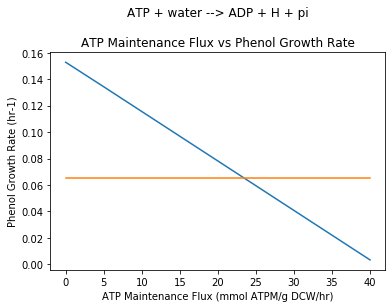

In [5]:
plt.plot(list(atp_growth_data.keys()), list(atp_growth_data.values()))
plt.plot([0, 40], [phenol_growth_rate, phenol_growth_rate])
plt.title('ATP + water --> ADP + H + pi\n\nATP Maintenance Flux vs Phenol Growth Rate')
plt.ylabel('Phenol Growth Rate (hr-1)')
plt.xlabel('ATP Maintenance Flux (mmol ATPM/g DCW/hr)')
plt.show()

### 6. Run FVA to calculate phenol ATP maintenance flux value

In [6]:
with model:
    # reset atm maintenance bounds
    model.reactions.get_by_id('ATPM').lower_bound = 0
    model.reactions.get_by_id('ATPM').upper_bound = 1000
    
    # set up objective function
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Phenol').upper_bound = phenol_growth_rate

    # set up medium
    medium = model.medium 
    medium = {key:1000 for (key,value) in model.medium.items()}
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    model.reactions.get_by_id('Growth').upper_bound = 0
    model.reactions.get_by_id('Growth').lower_bound = 0

    #remove all non-phenol carbon sources:
    medium["EX_glc__D_e"] = 0
    medium['EX_guaiacol_e'] = 0
    medium['EX_vanlt_e'] = 0
    medium['EX_tag'] = 0
    medium["EX_phenol_e"] = phenol_uptake_rate

    model.medium = medium    
    display(model.medium)
    
    results = cobra.flux_analysis.flux_variability_analysis(model, ['ATPM'], fraction_of_optimum=1)
    display(results)

{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_phenol_e': 1.3520722607432194}

,minimum,maximum
ATPM,0.0,23.389117


### 7. Run glucose FBA with many levels of ATP maintenance flux

In [7]:
atp_growth_data = {}

# try every flux from 0 to 100 with a step of 10
for atp_maintenance_flux in range(0, 140, 5):
    # fix atp maintenance flux
    model.reactions.get_by_id('ATPM').lower_bound = atp_maintenance_flux
    model.reactions.get_by_id('ATPM').upper_bound = atp_maintenance_flux
    
    # run FBA
    glucose_fba_solution = get_FBA_solution(model, 'glucose', substrate_uptake_rate=glucose_uptake_rate, verbose=False) 
    
    # save data pair of atp maintenance flux and growth rate
    atp_growth_data[atp_maintenance_flux] = glucose_fba_solution.objective_value
    
print(atp_growth_data)

{0: 0.48437893365730017, 5: 0.4665883997976289, 10: 0.44879786593795773, 15: 0.4310073320782865, 20: 0.41321679821861523, 25: 0.3954262643589435, 30: 0.37763573049927235, 35: 0.3598451966396008, 40: 0.34205466277993, 45: 0.3242641289202586, 50: 0.30647359506058686, 55: 0.2886830612009162, 60: 0.27089252734124547, 65: 0.2531019934815755, 70: 0.23531145962190395, 75: 0.21752092576223236, 80: 0.1997303919025607, 85: 0.1819398580428908, 90: 0.16414932418321923, 95: 0.14635879032354754, 100: 0.128568256463876, 105: 0.11077772260420446, 110: 0.09298718874453453, 115: 0.07519665488486452, 120: 0.05740612102519253, 125: 0.039615587165522624, 130: 0.021825053305851064, 135: 0.004034519446179508}


### 8. Plot glucose growth rate vs. ATP maintenance flux

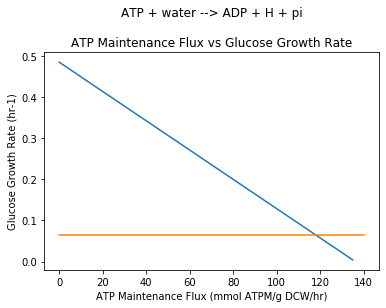

In [8]:
plt.plot(list(atp_growth_data.keys()), list(atp_growth_data.values()))
plt.plot([0, 140], [glucose_growth_rate, glucose_growth_rate])
plt.title('ATP + water --> ADP + H + pi\n\nATP Maintenance Flux vs Glucose Growth Rate')
plt.ylabel('Glucose Growth Rate (hr-1)')
plt.xlabel('ATP Maintenance Flux (mmol ATPM/g DCW/hr)')
plt.show()

### 9. Run FVA to calculate glucose ATP maintenance flux value

In [9]:
with model:
    # reset atm maintenance bounds
    model.reactions.get_by_id('ATPM').lower_bound = 0
    model.reactions.get_by_id('ATPM').upper_bound = 1000
    
    # set up objective function
    model.objective = 'Growth_Glucose'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = glucose_growth_rate

    # set up medium
    medium = model.medium 
    medium = {key:1000 for (key,value) in model.medium.items()}
    model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
    model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
    model.reactions.get_by_id('Growth').upper_bound = 0
    model.reactions.get_by_id('Growth').lower_bound = 0

    #remove all non-glucose carbon sources:
    medium["EX_glc__D_e"] = glucose_uptake_rate
    medium['EX_guaiacol_e'] = 0
    medium['EX_vanlt_e'] = 0
    medium['EX_tag'] = 0
    medium["EX_phenol_e"] = 0

    model.medium = medium    
    display(model.medium)
    
    results = cobra.flux_analysis.flux_variability_analysis(model, ['ATPM'], fraction_of_optimum=1)
    display(results)

{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 3.5824709208160685,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0}

,minimum,maximum
ATPM,0.0,117.728548
